<h1 align="center"> Support Vector Machines</h1> 
<h2 align="center"> Tutorial 05 - Introduction to Machine Learning </h2> 

In [57]:
# Standard Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Goals Tutorial
* Using Support Vector Machines (SVMs) with scikit-learn library to apply multi-class classification with both linear and non-linear kernel
* Tune the parameters of the Support Vector Machines and see the changes in accuracy
* Observing the decision surfaces with the help of Matplotlib library

### Problem and Dataset
We will make use of the Medical Appointments dataset which is available via [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments). The dataset contains 110527 instances about medical appointments of patients in Brazil. Information about the patient and the appointment details are included. Target feature to predict is `No-show`, describing whether the patient showed up yes/no. 15 variables are included. The somewhat unclear variables are explained below: <br>
- `Scholarship`: whether or not a person is participating in a social welfare program of the Government of Brazil that provides financial aid to poor families
- `Neighbourhood`: Where the appointment takes place.
- `Hipertension`: whether or not a person has high blood pressure
<br>

**Q: To what extend we can classify no-shows for the appointments by using Support Vector Machines?**

In [59]:
df = pd.read_csv("KaggleV2-May-2016.csv")
df.head(4)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No


In [60]:
df = df.sample(frac=0.5) # randomly select 40% of the dataset (computational time is too long on my laptop)
print(len(df))

55264


## Pre-processing
- Checking data types
- Feature engineering
- Class imbalance 

#### Data Types

In [63]:
# Checking data types and missing values
print('Total number of instances:', len(df), '\n')
df.info()

Total number of instances: 55264 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55264 entries, 75478 to 41258
Data columns (total 14 columns):
PatientId         55264 non-null float64
AppointmentID     55264 non-null int64
Gender            55264 non-null object
ScheduledDay      55264 non-null object
AppointmentDay    55264 non-null object
Age               55264 non-null int64
Neighbourhood     55264 non-null object
Scholarship       55264 non-null int64
Hipertension      55264 non-null int64
Diabetes          55264 non-null int64
Alcoholism        55264 non-null int64
Handcap           55264 non-null int64
SMS_received      55264 non-null int64
No-show           55264 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 6.3+ MB


- There are no missing values

#### Q1: Which features do you think need to be pre-processed before being fed to the SVM algorithm? Why?  How can we do that?

**Answer:**
- Mostly numerical features, some textual features (strings)
    - Note: SVM cannot deal with non-numeric features. Hence, we need to first transform the string values into numbers by using *binarization*. 
    - We could make use of the Pandas binarization method `get_dummies()`
    - Features to binarize: Gender, No-Show, Neighbourhood
- Date features should be meaningful
    - Transform the features to date_time objects
    - Derive the number of days between the day the appointment was scheduled and the day of the appointment as this is the information that is useful to learn for the algorithm, not the dates themselves

#### Feature Engineering

In [68]:
# The string Date values need to be transformed into Datetime
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"], format='%Y%m%d %H:%M:%S') 
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"], format='%Y%m%d %H:%M:%S') 

# New meaningful feature (feature engineering)
df["DaysWaitingForAppointment"] = df.apply(lambda x: (x["AppointmentDay"]-x["ScheduledDay"]).days, axis=1)

#### Removing `Neighbourhood` variable
- Dropping as the feature is not good enough in its current form
- Requires more feature engineering, such as:
    - Merging into larger neighbourhoods that are comparable in size
    - Equally sized bins indicate if there is a relation with neighborhood (and if it's of comparable size)
    - Or you could normalize all neighbourhoods by comparing them to the inhabitants in that neighbourhood (density)
- Now, we might draw incorrect conclusions
- However, by dropping it you assume that there is no influence of the neighborhoods

In [70]:
print('Number of Neighbourhoods:', len(df.Neighbourhood.value_counts()))
df.Neighbourhood.value_counts()[-8:]

Number of Neighbourhoods: 80


UNIVERSITÁRIO                  75
NAZARETH                       60
MORADA DE CAMBURI              53
PONTAL DE CAMBURI              32
ILHA DO BOI                    16
AEROPORTO                       5
ILHA DO FRADE                   4
ILHAS OCEÂNICAS DE TRINDADE     1
Name: Neighbourhood, dtype: int64

#### Numeric features

In [72]:
# Checking whether the distributions of the numeric features make sense
df.iloc[:, 2:].describe()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,DaysWaitingForAppointment
count,55264.000000,55264.000000,55264.000000,55264.000000,55264.000000,55264.000000,55264.000000,55264.000000
mean,36.930063,0.099975,0.196529,0.070842,0.030544,0.020936,0.322362,9.236555
std,23.122216,0.299969,0.397377,0.256563,0.172081,0.154947,0.467385,15.409652
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000
25%,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,14.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,178.000000


#### Q2: Which feature(s) do you think need some pre-processing? Why? What should be done?

#### Answer
- Remove illogical values
    - Make age > 0 
    - Make days_difference > 0 and < 30

#### Removing incorrect instances

In [76]:
# Appointment cannot happen before being scheduled
df = df.loc[(df.DaysWaitingForAppointment >= 0) & (df.DaysWaitingForAppointment <= 30), :]

# Minimal age = 0
df = df.loc[(df.Age >= 0), :]

#### Binarizing 

In [78]:
input_variables = ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 
                   'Handcap', 'SMS_received', 'DaysWaitingForAppointment']

X = df.loc[:, input_variables] #  .loc means: all instances (:), only selected columns

# Binarizing input feautres
# Note that drop_first removes redundant information (e.g. if male than its known that you're not female)
X = pd.get_dummies(X, drop_first=True)

# Binarize target
y = [1 if value == "Yes" else 0 for value in df["No-show"].values]

print(X.shape) # 93 columns 

(31126, 9)


#### Class Imbalances
- Class imbalances exist 
- However, SVMs are pretty robust for datasets with a lot of variance
- Hence, no outliers need to be removed (only in case of very bad results)

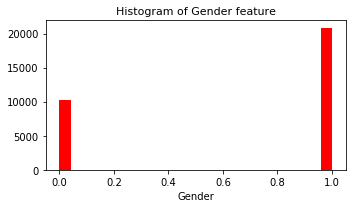

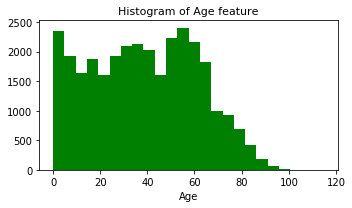

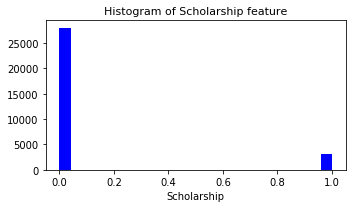

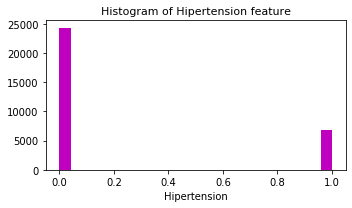

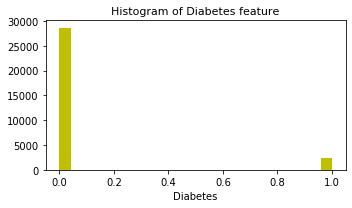

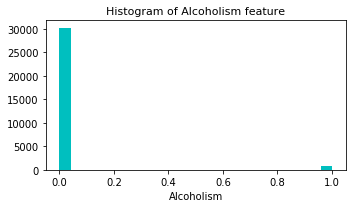

In [80]:
import seaborn as sns

# Binarize Gender (from string to numeric)
df["Gender"] = df.Gender.apply(lambda x: 0 if x=='M' else 1)

colors = ['r','g','b','m','y','c']
for feature,unit,color in zip(input_variables, input_variables, colors):
    plt.figure(figsize=(5,3))
    
    plt.subplot(1, 1, 1)
    plt.hist(df[feature], color=color, bins=24)
    plt.title('Histogram of {} feature'.format(feature), fontsize=11)
    plt.xlabel(unit)
    
    plt.tight_layout()
    plt.show;

### Do you want to learn more about pre-processing?

There are some useful Python kernels in Kaggle. You can check out this kernel as a starting point: https://www.kaggle.com/omarelgabry/a-journey-through-titanic

## Dimensionality Reduction
- We are evaluating the data in 2D by applying a Dimensionality Reduction technique. Here, we use the advanced t-SNE technique
- Studying this graph can offer clues on how complex the kernel needs to be to nicely seperate the data
- You are studying the geometrical properties of the data when doing so
- Conclusion: the data is complex and a linear kernel might not be sufficient (cannot seperate the data)
- Please note that this is a more complex topic and we will not dive into it now 

In [83]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)
dim_df = pd.DataFrame(X_tsne, columns=["Dimension_1", "Dimension_2"])

/Users/Bellerofonte/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Bellerofonte/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


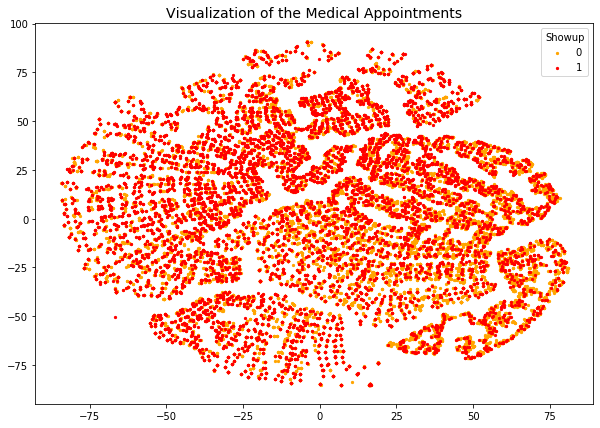

In [84]:
targets = [0, 1]
colors = ['orange', 'red']

fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(1,1,1) 
for target, color in zip(targets, colors):
    indices_to_keep = [idx == target for idx in y]
    ax.scatter(dim_df.loc[indices_to_keep, "Dimension_1"],
               dim_df.loc[indices_to_keep, "Dimension_2"],
               c = color,
               s = 5)
    ax.set_title('Visualization of the Medical Appointments', fontsize = 14)
    ax.grid()
    
ax.legend(targets, title="Showup")
plt.show()

## SVM explained
The general optimization problem of the SVM is to maximize the margin to the nearest training-data point of any class by using a hyper-plane that separates the decision boundaries.

**Q: Why are we maximizing the margin?**

#### Answer
A line is bad if it passes too close to the points because it will be noise sensitive and it will not generalize correctly. Therefore, our goal should be to find the line passing as far as possible from all points.

## Support Vector Machines

We will first apply the Linear Kernel Support Vector Machines. While maximizing the margin according to the hyperplane, the simple equation of the SVM allows us to impose a cost parameter, $C$. And we can tune that parameter while selecting the best model to train.

$$min  \frac{\left\| w \right\|}{2} + C \sum_{k=1}^R \epsilon_k$$

**Note that a simple Linear SVM can only classify linearly separable data.** We will see non-linear kernels in the second exercise. 

### Exercise 1:

In this exercise you will be training your own Linear Support Vector Classifier using Grid Search to optimize the model parameters. For measuring model performance, we will make use of accuracy and a held out test set. Scikit-Learn contains the `svm` library, which contains built-in classes for different SVM algorithms. Since we are going to perform a classification task, we will use the support vector *classifier* class, which is written as `SVC()` in this library.

    1. Split your dataset into train and test sets by using a 70/30 train/test split
       Select a random state of 42
    2. Scale the data as the scale of the data differs per feature
       Use the `Normalizer()` from scikit-learn to fit and transform your data
       Store the transformed data in a new variable (e.g. X_train_scaled)
       Note: avoid information spillover from your test set (check how to in tutorial 2)
    3. Initialize a SVM Classifier `SVC()`* and assign the model to a new variable `SVM_clf`
       Make use of a linear kernel by using the parameter kernel="linear"
    4. Create a dictionary with possible values for SVM hyperparameter `C` (penalty parameter of the error term)
       Information on this parameter can be found in the documentation
       Use the following values: [0.001, 0.01, 0.1, 1, 10]
    5. Initialize GridSearch and make use of the created parameter grid, the SVM classifier and 3 folds (cv)
       Check tutorial 4 for a GridSearch example
    6. Execute GridSearch by fitting it on the training data and evaluating the final model score on the test data using the .score(input, target) method (check in documentation)
    7. Output which value of C was selected for the final model

Documentation can be found here for [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html) , [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [91]:
from sklearn.model_selection import (cross_val_score, GridSearchCV, train_test_split)
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# 2. Scale the input data
scaler = Normalizer()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Initialize SVM
SVM_linear_clf = SVC(kernel="linear", random_state=42)

# 4. Paramter dictionary
parameter_grid = {"C": [0.001, 0.01, 0.1, 1, 10]}

# 5. Initialize GridSearchCV
clf = GridSearchCV(estimator=SVM_linear_clf,
                   param_grid=parameter_grid,
                   cv=3)

# 6. Execute GridSearch 
clf.fit(X_train_scaled, y_train)
print('Accuracy:', clf.score(X_test_scaled, y_test))

# 7. Best param value
print(clf.best_params_)

Accuracy: 0.7292782180338402
{'C': 0.001}


### Exercise 2: Using a non-linear kernel
Replicate the exercise above but make use of a non-linear kernel of `SVC()`. How does your accuracy change?


In [93]:
# 3. Initialize SVM
SVM_non_linear = SVC(kernel="rbf", gamma='auto', random_state=42) # rbf or poly are used for non-linear hyper-planes
# 'auto' is added to avoid warning

# 5. Initialize GridSearchCV
clf2 = GridSearchCV(estimator=SVM_non_linear,
                    param_grid=parameter_grid,
                    cv=3)

# 6. Execute GridSearch 
clf2.fit(X_train_scaled, y_train)
print('Accuracy:', clf2.score(X_test_scaled, y_test))

# 7. Best param value
print(clf2.best_params_)

Accuracy: 0.7292782180338402
{'C': 0.001}
